## Convert video in DVS images

In [1]:
#load modules
import numpy as np
from matplotlib import pyplot as plt
import data_utils
import tiffcapture as tc 
import cv2
from PIL import Image
import matplotlib.animation as animation
from scipy import ndimage

In [2]:
#set input and output paths
datasetpath='C:/Users/Gemma/Desktop/TubingenSecondment/dataset'
outputpath='C:/Users/Gemma/Desktop/TubingenSecondment/dataset'

#input images
train_image_path=datasetpath+"/train.tiff"
test_image_path=datasetpath+"/test.tiff"

## Functions

In [3]:
def form_tiff_to_listarray(filename):
    print("Convert tiff file")
    tiff = tc.opentiff(filename)
    listarray=[]
    for img in tiff:
        listarray.append(img)
    listarray_array=np.asarray(listarray)
    return listarray_array

In [4]:
def create_DVSvideo(filename,data,fps):
    print("Create video")
    size= (data.shape) [1:3]
    writer = cv2.VideoWriter(filename,cv2.VideoWriter_fourcc(*'XVID'),fps,size,True)
    for i in range(len(data)):
        frame=(data[i,:,:]+1)*(255/2)
        frame=np.stack([frame,frame,frame],axis=2)
        writer.write(np.uint8(frame))         
    return

In [5]:
#input video array frame, height, width
#DHW - (depth, height, width) ????
def DVSimages(video,thrP,thrN):
    video_shape=  (video.shape)[1:3]
    video_length=  (video.shape)[0] 
    state_img=video[0,:,:]
    DVSimg=np.zeros(video_shape, dtype=np.int16)
    DVSvideo=[]
    DVSvideo.append(DVSimg)

    for i in range(video_length):
        
        img=np.int16(video[i,:,:])
        #check if the changes surpass a fix threshold (different thresholds for ON and OFF)
        tmp=img-state_img

        onEvents=tmp>thrP
        offEvents=tmp<-thrN
        
        #DVS image
        DVSimg=np.zeros(video_shape, dtype=np.int16)
        DVSimg[onEvents]=1
        DVSimg[offEvents]=-1
        DVSvideo.append(DVSimg)
        
        state_img[onEvents]=img[onEvents]
        state_img[offEvents]=img[offEvents]
    
    DVSvideo_array=np.asarray(DVSvideo)

    return DVSvideo_array

In [11]:
#DHW - (depth, height, width) ????
def DVS_BC_images(video,thrP,thrN,exc,inh):
    video=video_test
    video_shape=np.asarray(video.shape)
    video_imgsize=  (video_shape)[1:3]
    video_length=  (video_shape)[0] 

    state_img=video[0,:,:]
    DVSimg=np.zeros(video_imgsize, dtype=np.int16)
    DVSvideo=[]
    DVSvideo.append(DVSimg)
    k = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    #k = np.array([[-inh,-inh,-inh],[-inh,exc,-inh],[-inh,-inh,-inh]])

    for i in range(video_length):
        img=np.int16(video[i,:,:])
        #check if the changes surpass a fix threshold (different thresholds for ON and OFF)
        img_conv=ndimage.convolve(img, k, mode='constant', cval=0.0)

        tmp=img_conv-state_img

        onEvents=tmp>thrP
        offEvents=tmp<-thrN

        #DVS image
        DVSimg=np.zeros(video_imgsize, dtype=np.int16)
        DVSimg[onEvents]=1
        DVSimg[offEvents]=-1
        DVSvideo.append(DVSimg)

        state_img[onEvents]=img[onEvents]
        state_img[offEvents]=img[offEvents]

    DVSvideo_array=np.asarray(DVSvideo)

    return DVSvideo_array

## Main

In [7]:
thrP_perc=0.10# threshold in %
thrN_perc=0.10#
min_value=0
max_value=255
thrP=thrP_perc*(max_value-min_value)#positive threshold in DN 
thrN=thrN_perc*(max_value-min_value)#negative threshold in DN (positive value)
print("Positive threshold:",thrP)
print("Negative threshold:",thrN)

Positive threshold: 25.5
Negative threshold: 25.5


In [8]:
#import video 
#TEST
video_test=form_tiff_to_listarray(test_image_path)
print("number video frame",video_test.shape)
#TRAIN
video_train=form_tiff_to_listarray(train_image_path)
print("number video frame",video_train.shape)

Convert tiff file
number video frame (749, 64, 64)
Convert tiff file
number video frame (16199, 64, 64)


255
0


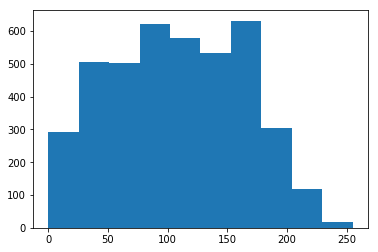

In [9]:
#statistics
plt.hist(video_test[0,:,:].flatten())
print(video_test.max())
print(video_test.min())

### DVS standard function

(array([ 3647828.,        0.,        0.,        0.,        0., 59086777.,
               0.,        0.,        0.,  3620595.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

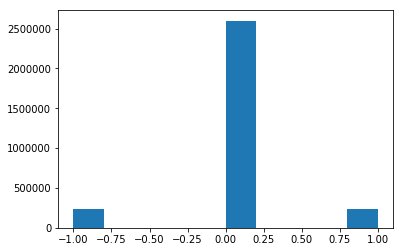

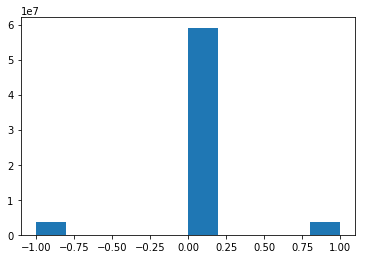

In [277]:
#TEST
DVSvideo_test=DVSimages(video_test,thrP,thrN)
#TRAIN
DVSvideo_train=DVSimages(video_train,thrP,thrN)   

plt.hist(DVSvideo_test.flatten())
plt.figure()
plt.hist(DVSvideo_train.flatten())

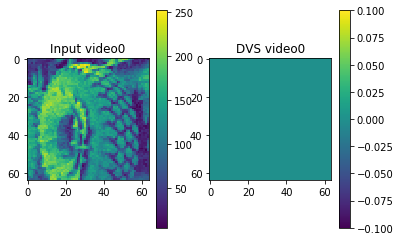

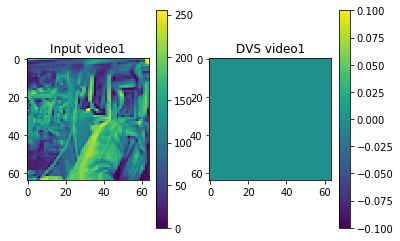

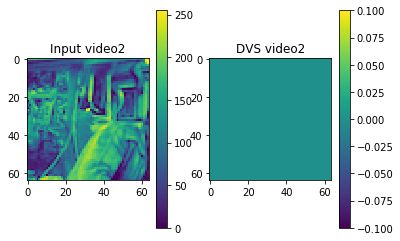

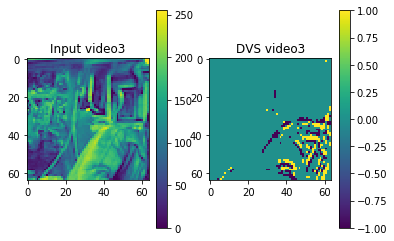

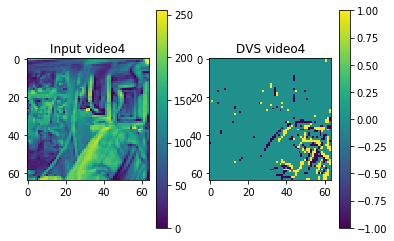

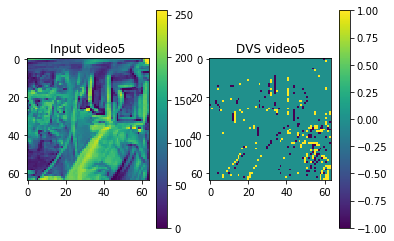

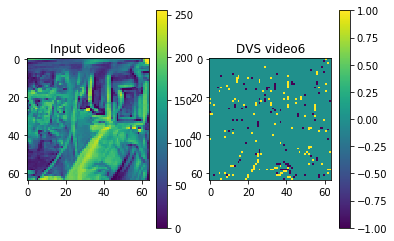

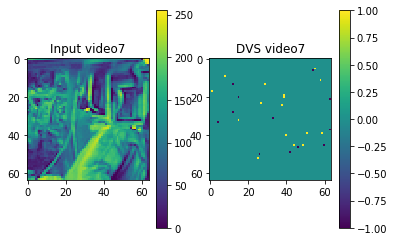

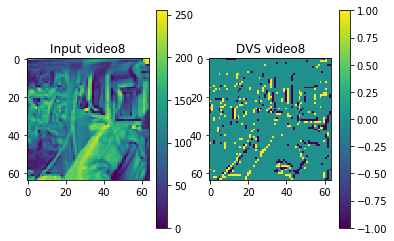

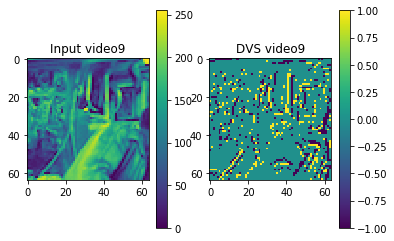

In [279]:
#Plot images
num_of_frame=10
array1=video_test
array2=DVSvideo_test
title1="Input video"
title2="DVS video"


for i in range(num_of_frame):
        plt.figure()
        plt.subplot(121)
        plt.imshow(array1[i,:,:])
        plt.title(title1+str(i))
        plt.colorbar()
        plt.subplot(122)
        plt.title(title2+str(i))
        plt.imshow(array2[i,:,:])
        plt.colorbar()

In [ ]:
#Save .avi video
train_image_output_path=(train_image_path.replace(".tiff", "")+"_DVS_"+str(int(thrP_perc*100))+".avi").replace(datasetpath,outputpath)
test_image_output_path=(test_image_path.replace(".tiff", "")+"_DVS_"+str(int(thrP_perc*100))+".avi").replace(datasetpath,outputpath)

fps=30

print(train_image_output_path)
print(test_image_output_path)
create_DVSvideo(train_image_output_path,DVSvideo_train,fps)
create_DVSvideo(test_image_output_path,DVSvideo_test,fps)

In [ ]:
#Save .npy video
train_image_output_path=(train_image_path.replace(".tiff", "")+"_DVS_"+str(int(thrP_perc*100))+".npy").replace(datasetpath,outputpath)
test_image_output_path=(test_image_path.replace(".tiff", "")+"_DVS_"+str(int(thrP_perc*100))+".npy").replace(datasetpath,outputpath)

print(train_image_output_path)
print(test_image_output_path)
np.save(train_image_output_path,DVSvideo_train)
np.save(test_image_output_path,DVSvideo_test)

In [ ]:
#Plot images
num_of_frame=10

for i in range(num_of_frame):
    frame=(DVSvideo_test[i,:,:]+1)*(256/2)
    plt.figure()
    plt.imshow(frame,cmap='gray')
    plt.colorbar()

### DVS Bipolar cell function

(array([ 864517.,       0.,       0.,       0.,       0., 1048852.,
              0.,       0.,       0., 1158631.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

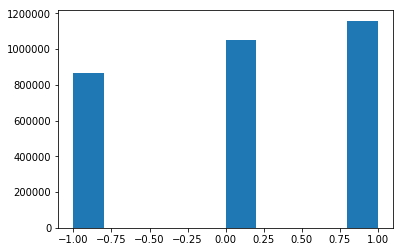

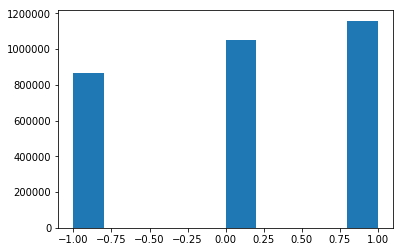

In [12]:
exc=0.8
inh=0.2

#TEST
DVS_BC_video_test=DVS_BC_images(video_test,thrP,thrN,exc,inh)
#TRAIN
DVS_BC_video_train=DVS_BC_images(video_train,thrP,thrN,exc,inh)   

plt.hist(DVS_BC_video_test.flatten())
plt.figure()
plt.hist(DVS_BC_video_train.flatten())

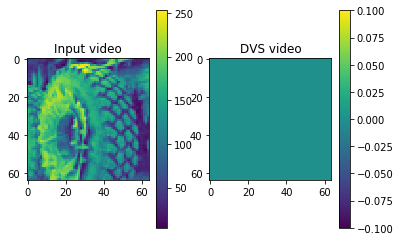

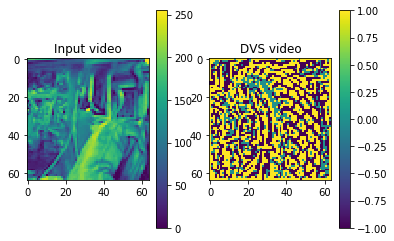

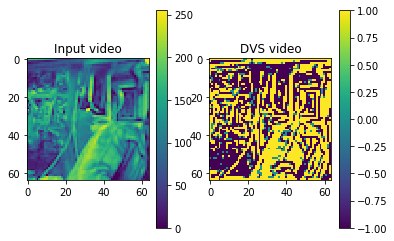

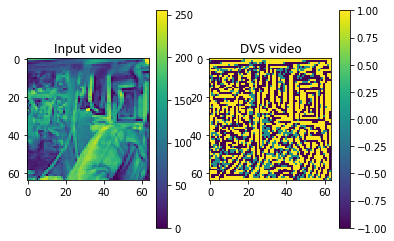

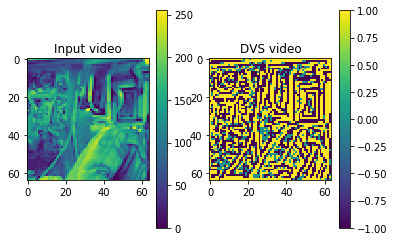

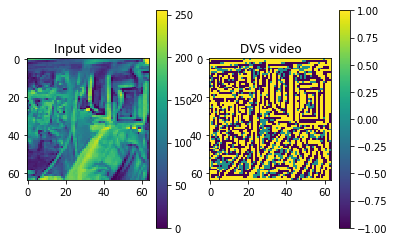

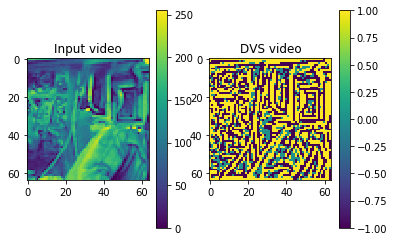

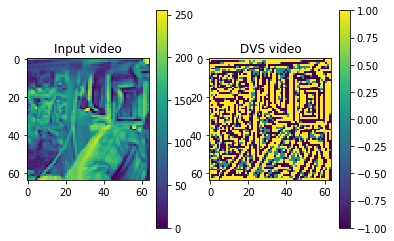

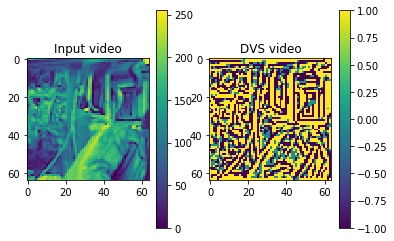

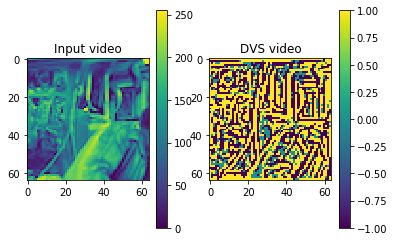

In [13]:
#Plot images
num_of_frame=10
array1=video_test
array2=DVS_BC_video_test
title1="Input video"
title2="DVS video"


for i in range(num_of_frame):
        plt.figure()
        plt.subplot(121)
        plt.imshow(array1[i,:,:])
        plt.title(title1)
        plt.colorbar()
        plt.subplot(122)
        plt.title(title2)
        plt.imshow(array2[i,:,:])
        plt.colorbar()

In [14]:
#Save .avi video
train_image_output_path=(train_image_path.replace(".tiff", "")+"_DVS_"+str(int(thrP_perc*100))+"_BC.avi").replace(datasetpath,outputpath)
test_image_output_path=(test_image_path.replace(".tiff", "")+"_DVS_"+str(int(thrP_perc*100))+"_BC.avi").replace(datasetpath,outputpath)

fps=30

print(train_image_output_path)
print(test_image_output_path)
create_DVSvideo(train_image_output_path,DVS_BC_video_train,fps)
create_DVSvideo(test_image_output_path,DVS_BC_video_test,fps)

C:/Users/Gemma/Desktop/TubingenSecondment/dataset/train_DVS_10_BC.avi
C:/Users/Gemma/Desktop/TubingenSecondment/dataset/test_DVS_10_BC.avi
Create video
Create video
